## Group 4

### Content
1. Data Exploration
2. Data Preprocessing
3. Models
4. Results & Comparison
5. Summary & Further Improvement

## Data Exploration

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
df_train = pd.read_csv('Data/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
labels = df_train['tags'].apply(lambda x: x.split(' '))

In [4]:
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=800, width=800, title='Distribution of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-label-dist')

In [5]:
# Co-occurence Matrix
com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

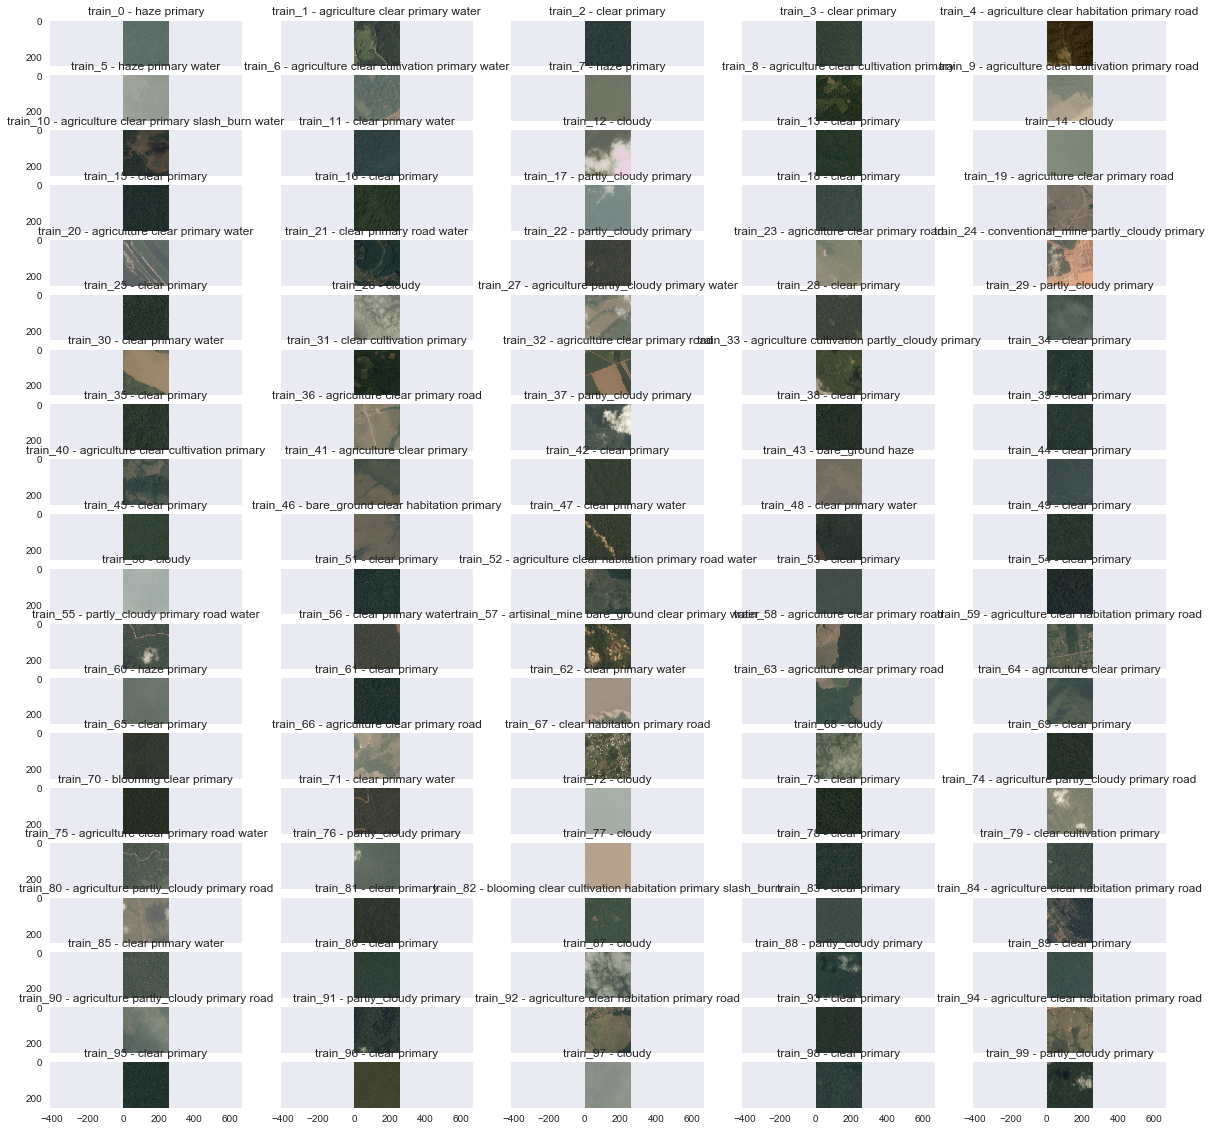

In [12]:
# show the first 100 images 
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(20,5, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:100].values:
    img = cv2.imread('Data/train-jpg/{}.jpg'.format(f))
    ax[i // 5, i % 5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 5, i % 5].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()

In [14]:
#get the whole type of the tags
count_line_num1 = sum(1 for line in open('Data/train_v2.csv'))
count_line_num1 -= 1
count_line = 0
matrix_train = np.empty([count_line_num1, 2], dtype=object)
with open('Data/train_v2.csv') as in_file:
    in_file.readline()
    for line in in_file.readlines():
        newline = line.split(',')
        #remove /n for each row
        newline[-1] = newline[-1].strip()
        matrix_train[count_line] = newline
        count_line += 1
#to deal with missing data
matrix_train[matrix_train == ''] = 'nan'
matrix_train
#get the length of unique labels
unique_items = np.unique(matrix_train[:, 1])
print ("The total # of combination of the label:", len(unique_items))

The total # of combination of the label: 449


## Data Preprocessing

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import sklearn

[[ 106.  113.   98. ...,   99.  103.   84.]
 [  56.   62.   48. ...,   85.  102.  100.]
 [  58.   57.   41. ...,   62.   62.   45.]
 ..., 
 [ 134.  142.  132. ...,  136.  149.  137.]
 [  57.   63.   43. ...,   63.   67.   51.]
 [ 105.  119.  119. ...,   43.   54.   39.]]


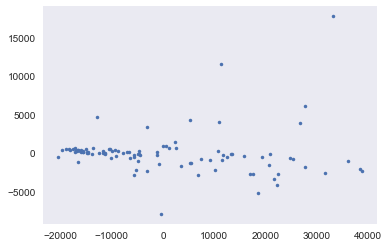

In [17]:
#perform PCA on the data
list_of_image = []

image_matrix = np.zeros((100, 196608))
pca=PCA()
count_rows = 0
for f, l in df_train[:100].values: 
    im = cv2.imread('Data/train-jpg/{}.jpg'.format(f))
    #print (len(im))
    #print (len(im[255]))
    im2 = np.asarray(im).reshape(-1)
    #a = np.zeros((3, 3))
    #b = np.asarray(a).reshape(-1)
    #print (im2)
    #print (len(im2))
    image_matrix[count_rows: ] = im2
    count_rows += 1
#Xpca=pca.fit_transform(X)
#plt.plot(Xpca[:,0],Xpca[:,1],'.')
print (image_matrix)

imagePca=pca.fit_transform(image_matrix)
plt.plot(imagePca[:,0],imagePca[:,1],'.')


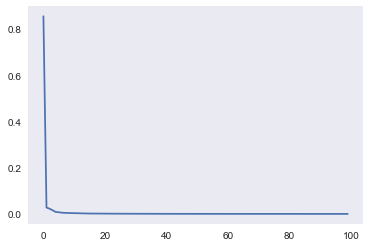

In [18]:
#evaluate how many Principal Component are important
plt.plot(pca.explained_variance_ratio_)

In [20]:
#Binarize labels y, prepare for model

lb = MultiLabelBinarizer()
df_train['split_tags'] = df_train['tags'].map(lambda row: row.split(" "))
y = lb.fit_transform(df_train['split_tags'])
print(y[:5,:], lb.classes_)

[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]] ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [21]:
# Resize jpg to rescaled_dim and MinMax jpg data

n_samples = 500
rescaled_dim = 64
y = y[:n_samples]

X = np.squeeze(np.array([cv2.resize(plt.imread('Data/train-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df_train.head(n_samples)['image_name'].values]))
#X = MinMaxScaler().fit_transform(X)
print(X.shape,y.shape)

(500, 16384) (500, 17)


## Models (Core, CNN1, CNN2)

### Core Layer 

In [22]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [27]:
# Core Layer
model1 = Sequential()

model1.add(Dense(72, input_dim=64*64*4, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(24, activation='relu'))
model1.add(Dense(17, activation='sigmoid'))

In [28]:
model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
model1.fit(X_train, y_train, epochs=50, batch_size=256)

In [31]:
y_pred1=model1.predict(X_test)

### CNN 1

In [35]:
dim=64
Xc=X.reshape(-1,dim,dim,4)
print(Xc.shape)

(500, 64, 64, 4)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(Xc, y, test_size=0.33)

In [37]:
#stanford model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model2 = Sequential()
input_shape=Xc.shape[1:]

model2.add(BatchNormalization(input_shape=input_shape))
        
model2.add(Conv2D(32, kernel_size=(3, 3),strides=1, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size=(4, 4),strides=1, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))

model2.add(Dropout(0.5))
model2.add(Dense(17, activation='sigmoid'))

In [38]:
from keras import optimizers
opt=optimizers.Adam(lr=0.001)

In [39]:
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [43]:
model2.fit(X_train, y_train, epochs=15, batch_size=64)

Epoch 1/15
335/335 [==============================] - 9s - loss: 0.2106 - acc: 0.9183     
Epoch 2/15
335/335 [==============================] - 8s - loss: 0.2179 - acc: 0.9159     
Epoch 3/15
335/335 [==============================] - 8s - loss: 0.2007 - acc: 0.9257     
Epoch 4/15
335/335 [==============================] - 8s - loss: 0.2086 - acc: 0.9206     
Epoch 5/15
335/335 [==============================] - 8s - loss: 0.1927 - acc: 0.9287     
Epoch 6/15
335/335 [==============================] - 8s - loss: 0.1953 - acc: 0.9215     
Epoch 7/15
335/335 [==============================] - 8s - loss: 0.1886 - acc: 0.9263     
Epoch 8/15
335/335 [==============================] - 9s - loss: 0.1879 - acc: 0.9254     
Epoch 9/15
335/335 [==============================] - 9s - loss: 0.1944 - acc: 0.9240     
Epoch 10/15
335/335 [==============================] - 9s - loss: 0.1843 - acc: 0.9310     
Epoch 11/15
335/335 [==============================] - 8s - loss: 0.1890 - acc: 0.9263   

In [44]:
y_pred2=model2.predict(X_test)

## CNN 2

In [46]:
model3 = Sequential()
model3.add(BatchNormalization(input_shape=(64, 64, 4)))
model3.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
        
model3.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
        
model3.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
        
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(17, activation='sigmoid'))

In [47]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [50]:
model3.fit(X_train, y_train,
          batch_size=64,
          epochs=15,
          verbose=1)

Epoch 1/15
335/335 [==============================] - 30s - loss: 0.5968 - acc: 0.7435    
Epoch 2/15
335/335 [==============================] - 28s - loss: 0.5619 - acc: 0.7821    
Epoch 3/15
335/335 [==============================] - 28s - loss: 0.5150 - acc: 0.8163    
Epoch 4/15
335/335 [==============================] - 28s - loss: 0.4703 - acc: 0.8427    
Epoch 5/15
335/335 [==============================] - 28s - loss: 0.4485 - acc: 0.8599    
Epoch 6/15
335/335 [==============================] - 30s - loss: 0.4077 - acc: 0.8709    
Epoch 7/15
335/335 [==============================] - 31s - loss: 0.3746 - acc: 0.8853    
Epoch 8/15
335/335 [==============================] - 28s - loss: 0.3529 - acc: 0.8901    
Epoch 9/15
335/335 [==============================] - 30s - loss: 0.3411 - acc: 0.8903    
Epoch 10/15
335/335 [==============================] - 28s - loss: 0.3195 - acc: 0.8973    
Epoch 11/15
335/335 [==============================] - 29s - loss: 0.3092 - acc: 0.8996  

In [52]:
y_pred3 = model3.predict(X_test, batch_size=128)

## Result of Models 

In [32]:
from sklearn.metrics import fbeta_score
def f2_score(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=2, average='samples')


def find_f2score_threshold(y_pred, y_true):
    best = 0
    best_score = -1
    totry = np.arange(0,1,0.005)
    for t in totry:
        score = f2_score(y_true, y_pred > t)
        if score > best_score:
            best_score = score
            best = t
    return best

In [ ]:
print(fbeta_score(y_test, np.array(y_pred) > find_f2score_threshold(y_pred, y_test), beta=2, average='samples'))

## Three models
Core 500 around 90% around 68%
CNN1 500 around 90% around 70%
CNN2 All around 94% around 85%

## Summary
1. Core model needs more epochs to achieve same score as CNN so we will focus more on CNN.
2. CNN1 only used 500 samples but according to results from Stanford University, it could achieve 0.8529 score after 25 epochs.
3. CNN2 used all train data and got the best score but after 15 epochs, loss still did not converge. A better model can be achieved after improvement.

## Further Improvement
1. Keep tuning CNN models
2. Try to feed all train data to CNN1 model and compare with CNN2
3. Solve problems:
   Improve data preprocessing according to the result of models
   Improve F2 score by training more data.